In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PatchCollection
import matplotlib

from IPython.display import Image, Audio, clear_output

import geopandas

import pickle

import zipfile

import os

import pysal as ps

import re
from textblob import TextBlob

import time

import shutil

from notify_run import Notify

from shapely import geometry
from shapely.ops import unary_union

from ast import literal_eval as make_tuple

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster

from zipfile import ZipFile

import imageio

import networkx as nx
from networkx.algorithms import community

from tqdm import tnrange, tqdm_notebook, tqdm

import dask.dataframe as dd

import collections

import torch
import torch.nn as nn
# from torch.utils.data import DataLoader, Dataset
import torch_geometric.nn as gnn
from torch_geometric.data import Data, DataLoader, Dataset

from scipy import sparse

# np.random.seed(0)

base_path = 'lawrence_leavenworth'

%matplotlib inline

In [2]:
torch.cuda.get_device_name(0)

GPU = True
device_idx = 1
if GPU:
    device = torch.device("cuda:" + str(device_idx - 1) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

print(device)

cuda:0


In [21]:
douglas = geopandas.read_file(base_path)

pkl = open(base_path + '_neighbors.pkl',"rb")
neighbors = pickle.load(pkl)
pkl.close()

douglas['neighbors'] = neighbors

In [22]:
douglas['populated'] = douglas.apply(lambda x: (x['2008_R'] + x['2008_D']) > 0, axis=1)

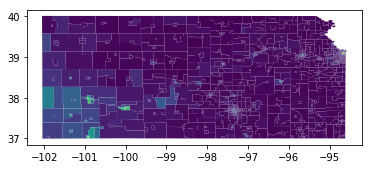

In [23]:
douglas.plot('His_Pct')

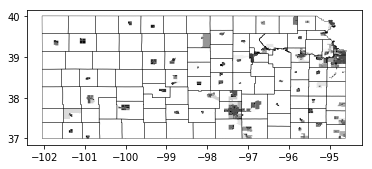

In [24]:
counties = []

for i in tqdm_notebook(douglas.COUNTYFP.unique()):
    county = douglas[douglas['COUNTYFP'] == i]['geometry']
    poly = unary_union(county)
    counties.append(poly)

    
county_frame = geopandas.GeoDataFrame([1 for _ in douglas.COUNTYFP.unique()], geometry=counties)

base = douglas.plot('Urb_Pct', cmap='binary')
base2 = county_frame.plot(0, edgecolor='black', cmap='gray', linewidth=0.35, facecolor='none', ax=base)
plt.show()

In [25]:
edges = list(douglas.neighbors)
adj_list = list(douglas.neighbors)
for i in range(len(edges)):
    edges[i] = [(i, e) for e in edges[i]]

nodes = list(douglas.index)
edges = [x for y in edges for x in y]

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

print(edges[:5])
print(len(adj_list))
print(G.number_of_nodes())
nx.is_connected(G)

[(0, 1), (0, 2), (0, 8), (0, 72), (0, 1288)]
2351
2351


True

In [26]:
counties = np.array(list(douglas['COUNTYFP'])).reshape(-1, 1)

one_hots = preprocessing.LabelEncoder().fit_transform(counties)

one_hots_tensor = torch.from_numpy(one_hots).long().to(device)

one_hots_tensor.shape

C:\Users\jxbox\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


torch.Size([2351])

In [27]:
sources = []
dests = []

for i in G.edges(data=False):
    sources.append(i[0])
    dests.append(i[1])

edges = [sources, dests]
edges = torch.tensor(edges).to(device)

print(edges.shape)

attr_tensor = torch.load(base_path + '_data_tensor.pt').to(device)

data = Data(x=attr_tensor, edge_index=edges, y=one_hots_tensor).to(device)

torch.Size([2, 6256])


In [28]:
# pop_2017 = list(pd.read_csv('2017_ks_pop/nhgis0010_ds233_20175_2017_blck_grp.csv')['AHY1E001'])

# douglas['Total2'] = pop_2017

In [29]:
print(sum(douglas['Total']))
# print(sum(douglas['Total2']))

pop = list(douglas['Total'])

data.x[:, -1] = torch.tensor(pop).to(device)
attr_tensor[:, -1] = torch.tensor(pop).to(device)

2853118


In [30]:
class Net(torch.nn.Module):
    def __init__(self, embedding_dim, num_counties, hidden_size, input_dim, num_districts):
        super(Net, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_counties = num_counties
        self.hidden_size = hidden_size
        self.input_dim = input_dim
        self.num_districts = num_districts
        
        self.conv1 = gnn.ChebConv(self.input_dim, self.hidden_size, 3)
        self.lin1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.conv2 = gnn.ChebConv(self.hidden_size, int(self.hidden_size/2), 2)
#         self.conv3 = gnn.ChebConv(int(self.hidden_size/2), self.embedding_dim, 2)
        self.conv3 = nn.Linear(int(self.hidden_size/2), self.embedding_dim)
        
        self.b1 = nn.BatchNorm1d(self.input_dim)
        self.b2 = nn.BatchNorm1d(self.hidden_size)
        self.b3 = nn.BatchNorm1d(int(self.hidden_size/2))
        
        self.b4 = nn.BatchNorm1d(int(self.hidden_size/2))
        self.b5 = nn.BatchNorm1d(self.hidden_size)
        self.b6 = nn.BatchNorm1d(self.input_dim)
        
        self.l1 = nn.BatchNorm1d(self.hidden_size)
        self.l2 = nn.BatchNorm1d(self.hidden_size)
        
#         self.conv4 = gnn.ChebConv(self.embedding_dim, int(self.hidden_size/2), 2)
        self.conv4 = nn.Linear(self.embedding_dim, int(self.hidden_size/2), 2)
        self.conv5 = gnn.ChebConv(int(self.hidden_size/2), self.hidden_size, 2)
        self.lin2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.conv6 = gnn.ChebConv(self.hidden_size, self.input_dim, 3)
        
        self.county_linear = nn.Linear(self.embedding_dim, self.num_counties)
                
        self.cluster_linear = nn.Linear(self.embedding_dim, self.num_districts)
        
        self.drop = nn.Dropout(0.125/self.embedding_dim)
        
        self.sp_linear = nn.Linear(self.embedding_dim, 1)
        
        self.activ = nn.ReLU()
        
    def encode(self, data):
        x, edge_index = data.x, data.edge_index
#         x = self.drop(x)
#         x = x + torch.randn(x.shape).detach().to(device) * 0.1
        
#         noise = torch.rand(x.shape)
#         x[noise < 0.025] = 0
        
        x = self.b1(x)
        x = self.conv1(x, edge_index)
        x = self.activ(x)
        x = self.b2(x)
        
        x = self.lin1(x)
        x = self.l1(x)
        x = self.activ(x)
        
#         x = self.dropout(x)
        x = self.conv2(x, edge_index)
                                  
        x = self.activ(x)
        x = self.b3(x)
        x = self.conv3(x)
        
        return x
    
    def sp(self, x):
        return self.sp_linear(x).squeeze()
    
    def decode(self, x, edge_index):
        
        x = self.drop(x)

        x = self.conv4(x)
        x = self.b4(x)
        x = self.activ(x)
                                  
        x = self.conv5(x, edge_index)
#         x = self.dropout(x)

        x = self.activ(x)
        x = self.l2(x)
        x = self.lin2(x)

        x = self.b5(x)
        x = self.activ(x)
        x = self.conv6(x, edge_index)
        x = self.b6(x)
        
        return x
        
    def predict_county(self, x, edge_index):

        x = self.drop(x)
        x = self.county_linear(x)
        
        return x
    
#     def cluster(self, y):
#         y = y.double()
#         q = torch.pow((1.0 + (torch.sum(torch.pow(torch.unsqueeze(y, dim=1) - self.centroids, 2), dim=2))), 2)
#         q = q / torch.sum(q, dim=1, keepdim=True)
        
#         return q

    def cluster(self, y, edge_index):
#         y = self.activ(y)
#         y = self.cluster_conv(y, edge_index)
#         y = self.activ(y)
        y = self.drop(y)
        y = self.cluster_linear(y)
        return y
        

    def forward(self, data):
        _, edge_index = data.x, data.edge_index
        encoded = self.encode(data)
        decoded = self.decode(encoded, edge_index)
        county_preds = self.predict_county(encoded, edge_index)
        clusters = self.cluster(encoded, edge_index)

        return encoded, decoded, county_preds, clusters


In [31]:
embedding_dim = 6
num_counties = douglas['COUNTYFP'].nunique()
hidden_dim = 4096
num_attrs = attr_tensor.shape[1]
num_districts = 4


weight_arr = np.ones(attr_tensor.shape[1])
weight_arr[-1] = 0
weight_arr[-2] = 0
weight_arr[-3] = 0
# weight_arr[5] = 0.5
weights = torch.tensor(weight_arr).float().to(device)
def weighted_mse(x, y):
    se = nn.MSELoss(reduction='mean')(x*weights, y*weights)
    return se

In [32]:
model = Net(embedding_dim, num_counties,
           hidden_dim, num_attrs, num_districts).to(device)

# optim = torch.optim.Adamax(model.parameters(), lr=0.01)

# encoded, decoded, county_preds, q = model(data)

# centroids = np.random.choice(douglas.shape[0], num_districts)

# arg_x = q.to("cpu").detach()
# douglas['district'] = np.argmax(arg_x, axis=1)
# # print(len(douglas['district'].value_counts()))

# comms = nx.community.asyn_fluidc(G, num_districts)

# target_tensor = torch.zeros(douglas.shape[0]).to(device).long()

# for idx, c in enumerate(comms):
#     c = list(c)
#     target_tensor[c] = idx
    
# while len(douglas['district'].value_counts()) != num_districts:
#     optim.zero_grad()
#     encoded, decoded, county_preds, q = model(data)
    
# #     loss = nn.CrossEntropyLoss()(q, target_tensor) + nn.MSELoss()(decoded, data.x)
#     loss = nn.CrossEntropyLoss()(q, target_tensor) + nn.CrossEntropyLoss()(county_preds, data.y) + nn.MSELoss()(decoded, data.x) * 0.05
    
# #     print(loss.item(), len(douglas['district'].value_counts()))
    
#     loss.backward()
#     optim.step()
    
# for _ in tqdm_notebook(range(25)):
#     optim.zero_grad()
#     encoded, decoded, county_preds, q = model(data)
    
# #     loss = nn.CrossEntropyLoss()(q, target_tensor) + nn.MSELoss()(decoded, data.x)
#     loss = nn.CrossEntropyLoss()(q, target_tensor) + nn.CrossEntropyLoss()(county_preds, data.y) + nn.MSELoss()(decoded, data.x) * 0.05
    
# #     print(loss.item(), len(douglas['district'].value_counts()))
    
#     loss.backward()
#     optim.step()
    
# arg_x = q.to("cpu").detach()
# douglas['district'] = np.argmax(arg_x, axis=1)
# douglas.plot('district')

In [ ]:
%matplotlib inline

final_epochs = 50
learning_rate = 0.005

if os.path.exists('runs_grp/'):
    os.rename('runs_grp/', 'del/')
    shutil.rmtree('del/')

os.mkdir('runs_grp/')

weight_arr = np.ones(attr_tensor.shape[1])
weight_arr[-1] = 0
weight_arr[-2] = 0
weight_arr[-3] = 0
# weight_arr[5] = 0.5
weights = torch.tensor(weight_arr).float().to(device)

def weighted_mse(x, y):
    se = nn.MSELoss(reduction='mean')(x*weights, y*weights)
    return se

data = data.to(device)
embeddings, _, _, _ = model(data)
embeddings = embeddings.detach()
embeddings_np = embeddings.to("cpu").to("cpu")

optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# optim = torch.optim.Adamax(model.parameters(), lr=learning_rate)

def size_con(x, y):
    x = torch.softmax(x, dim=1)
#     x = torch.sigmoid(x)
    
#     x = x * y.unsqueeze(1).repeat(1, x.shape[1]).double()
#     summed = torch.sum(x, dim=0)
#     return nn.L1Loss()(summed, torch.sum(y) * torch.ones(summed.shape).double().to(device) / num_districts).float()
    
    x = x * y.unsqueeze(1).repeat(1, x.shape[1]).double()
    summed = torch.mean(x, dim=0)
    summed = summed / (torch.sum(summed) + 1e-10)
    
    return nn.L1Loss()(summed, torch.ones(summed.shape).double().to(device) / num_districts).float()

def size_con2(x, coords):
    arg_x = x.to("cpu").detach()
    douglas['district'] = np.argmax(arg_x, axis=1)
#     print(douglas['district'].value_counts())
    loss = 0
    x = torch.softmax(x, dim=1)
    target = torch.ones(1).to(device) / num_districts
    tot = torch.sum(coords)
    target = tot / tot / num_districts

    for i in range(num_districts):
        vals = douglas[douglas['district'] == i].index
        subset = coords[vals]
        subset = torch.sum(subset) / tot
        
        loss += nn.L1Loss(reduction='sum')(subset, target)
        
    if loss.item() != loss.item():
        print("size failed")
        return
    return loss

def compact(x, coords):
    arg_x = x.to("cpu").detach()
    douglas['district'] = np.argmax(arg_x, axis=1)
#     print(len(douglas['district'].value_counts()))
    loss = 0
    x = torch.softmax(x, dim=1)
#     x = torch.sigmoid(x)

    for i in range(num_districts):
#         all_polys = geometry.multipolygon.MultiPolygon(list(douglas[douglas['district'] == i]['geometry']))
#         center = all_polys.centroid
#         centroid_tensor = torch.tensor((center.x, center.y)).to(device)
        
        vals = douglas[douglas['district'] == i].index
        centroid_tensor = coords[vals]
        subset = coords[vals]
        centroid_tensor = torch.mean(centroid_tensor, dim=0)
        
#         dists = nn.MSELoss()(subset, centroid_tensor * torch.ones(subset.shape).to(device)).detach()
#         centroid = torch.argmin(dists)
#         centroid_tensor = subset[centroid]
        
#         print(x.shape)
#         print(coords.shape)
#         print(centroid_tensor.shape)
        
        loss += nn.L1Loss()(coords * x[:, i].unsqueeze(1).repeat(1, 2), centroid_tensor * x[:, i].unsqueeze(1).repeat(1, 2))
        
    if loss.item() != loss.item():
        print("compactness failed")
        return
    return loss

mask = list(douglas['Urb_Pct'])
mask = torch.tensor(mask).float().to(device)

def instance_con(x):
    sums = torch.sum(torch.pow(x, 2), dim=1)
    sums = mask * sums
#     return torch.sum(sums).float() / mask.shape[0]
    return torch.sum(sums).float() * 0.1

def split(preds, counties):
    preds = torch.softmax(preds, dim=1)
    split_loss = 0
    for k in range(douglas['COUNTYFP'].nunique()):
        cur = preds[counties == k]
        split_loss += torch.mean(torch.std(cur, dim=1))
#         split_loss += nn.MSELoss(reduction='batchmean')(cur, cur[torch.randperm(cur.size()[0])])
        
    return split_loss

losses = []
kls = []
recons = []
sizes = []
bces = []

neg_list = [list(set(G.nodes) - set([n for n in G.neighbors(i)])) for i in G.nodes]
        
state = False
    
for i in tqdm_notebook(range(final_epochs)):
        
    total_loss = 0.
    iters = 0.
    size_loss = 0.
    kl_loss = 0.
    recon_loss = 0.
    bce_loss = 0.

    model.train()
    optim.zero_grad()
    

    encoded, decoded, county_preds, q = model(data)
    
    if i%25 == 0:
        douglas['district'] = np.argmax(q.to("cpu").detach(), axis=1)
        dists = []

#         for j in range(num_districts):
#             dist = douglas[douglas['district'] == j]['geometry']
#             poly = unary_union(dist)
#             dists.append(poly)
#         dists = geopandas.GeoDataFrame(list(range(num_districts)), geometry=dists)
#         base = douglas.plot('Urb_Pct', cmap='binary')
#         base2 = county_frame.plot(0, edgecolor='black', cmap='gray', linewidth=0.35, facecolor='none', ax=base)
#         dists.plot(0, edgecolor='black', cmap='tab20', linewidth=0.35, alpha=0.7, ax=base2)
        
        douglas.plot('district')
        plt.title("argmax " + str(i))
        plt.savefig('runs_grp/' + str(i) + '.png')
        plt.cla()
        plt.clf()
        plt.close('all')


    rec = weighted_mse(decoded, data.x) * 0.5
    
    l1 = 0
    for p in model.parameters():
        if p.requires_grad:
            l1 += torch.sum(torch.abs(p))
            
    l1 *= 0.1
    l1 /= sum(p.numel() for p in model.parameters() if p.requires_grad)

#     kl = KL(p, q).float(
    kl = size_con(q.double(), data.x[:,-1]) * 250
#     kl = size_con2(q.double(), data.x[:,-1])
    size = compact(q, attr_tensor[:,-3:-1]) * 5

#     size = size_con(q, data.x[:,-1])
#     size = torch.zero()

    bce_l = nn.CrossEntropyLoss()(county_preds, data.y) * 10
    
#     bce_l = split(q, data.y)
    
#     compactness = compact()

#     instance = instance_con(q)

#         loss = rec + size + bce_l + edge + 0.1 * kl
#     loss = bce_l + 2 * size + 0.1 * kl + rec + instance
#     loss = bce_l + rec * 0.05 + size + kl * 0.1

    neighbors = [int(np.random.choice([n for n in G.neighbors(i)])) for i in G.nodes]

#     neighbor_loss = nn.CosineEmbeddingLoss()(q, q[neighbors], torch.ones(encoded.shape[0]).to(device) * 1)
    neighbor_loss = nn.CosineEmbeddingLoss()(encoded, encoded[neighbors], torch.ones(encoded.shape[0]).to(device) * 1) * 5
    for _ in range(5):
#         negatives = [int(np.random.choice(range(G.number_of_nodes()))) for i in neg_list]
        negatives = np.random.choice(G.number_of_nodes(), G.number_of_nodes())
#         neighbor_loss += nn.CosineEmbeddingLoss()(q, q[negatives], torch.ones(encoded.shape[0]).to(device) * -1) / 6
        neighbor_loss += nn.CosineEmbeddingLoss()(encoded, encoded[negatives], torch.ones(encoded.shape[0]).to(device) * -1)
#     neighbor_loss *= 0.25
    
    neighbor_loss += nn.L1Loss()(q, q[neighbors])
    
    negatives = np.random.choice(G.number_of_nodes(), G.number_of_nodes())
#     paths = [nx.shortest_path_length(G, i, negatives[i]) for i in G.nodes]
#     paths = torch.tensor(paths).to(device).float()    
    paths = attr_tensor[:,-3:-1] - attr_tensor[negatives][:,-3:-1]
    paths = torch.pow(paths, 2)
    paths = torch.sum(paths, dim=1)
    paths = torch.sqrt(paths) * 5
    
    prods = model.sp((embeddings[negatives] + embeddings) / 2)

    if i%5 == 0:
        state = not state
    
    if state:
        loss = bce_l + rec + size + neighbor_loss + nn.MSELoss()(prods, paths)
    else:
        loss = bce_l + rec + kl + neighbor_loss + nn.MSELoss()(prods, paths)
    
#     loss += size * ((i+1)**0.7 - 1) / 0.7
#     loss += kl * ((i+1)**0.4 - 1) / 0.4
#     loss += bce_l * ((i+1)**0.4 - 1) / 0.3
    
    if loss.item() != loss.item():
        print(bce_l)
        print(rec)
        print(size)
        print(kl)
        break

    if (i+1)%5 == 0:
        print("Epoch: {:d} | Total Loss: {:.5f} | Compact: {:.5f} | Recon: {:.5f} | Pop: {:.5f} | BCE: {:.5f} | Adj: {:.5f}".format(
            i + 1, loss.item(), size.item(), rec.item(), kl.item(), bce_l.item(), nn.MSELoss()(prods, paths)))
    
    losses.append(loss.item())
    sizes.append(size.item())
    recons.append(rec.item())
    kls.append(kl.item())
    bces.append(bce_l.item())
    
    loss.backward()
    optim.step()

#     print(preds_idx)

# clear_output()


plt.plot(range(len(sizes)), sizes)
plt.title("compactness loss")
plt.show()

plt.plot(range(len(recons)), recons)
plt.title("recon loss")
plt.show()

plt.plot(range(len(kls)), kls)
plt.title("pop loss")
plt.show()

plt.plot(range(len(bces)), bces)
plt.title("bce loss")
plt.show()

plt.plot(range(len(losses)), losses)
plt.title("total loss")
plt.show()

Epoch: 5 | Total Loss: 199.89523 | Compact: 4.26093 | Recon: 0.71625 | Pop: 9.29072 | BCE: 38.00643 | Adj: 154.66042


In [ ]:
model.eval()

embeddings, _, _, clusters = model(data)

print(clusters.shape)

clusters_tensor = clusters
clusters = clusters.to("cpu").detach().numpy()

soft_clusters = torch.softmax(clusters_tensor, dim=1).detach().to("cpu").numpy()

In [ ]:
x = torch.softmax(clusters_tensor, dim=1).double()
y = attr_tensor[:,-1].double()
x = x * y.unsqueeze(1).repeat(1, x.shape[1]).double()
summed = torch.mean(x, dim=0)
summed = summed / (torch.sum(summed) + 1e-10)
# summed
print(soft_clusters[np.random.choice(clusters_tensor.shape[0], 5)])
torch.abs(summed - torch.ones(summed.shape).double().to(device)/num_districts)

In [ ]:
douglas['district'] = np.argmax(soft_clusters, axis=1)

dists = []
centroids = []
centroids2 = []
coords = attr_tensor[:,-3:-1]

for i in range(num_districts):
    dist = douglas[douglas['district'] == i]['geometry']
    poly = unary_union(dist)
    dists.append(poly)
    
#     all_polys = geometry.multipolygon.MultiPolygon(list(douglas[douglas['district'] == i]['geometry']))
#     center = all_polys.centroid
#     centroids.append([center.x, center.y])
    
#     vals = douglas[douglas['district'] == i].index
#     centroid_tensor = coords[vals]
#     subset = coords[vals]
#     centroids2.append(torch.mean(centroid_tensor, dim=0).to("cpu").detach().numpy())

centroids = np.array(centroids)
centroids2 = np.array(centroids2)
    
dists = geopandas.GeoDataFrame(list(range(num_districts)), geometry=dists)

base = douglas.plot('Urb_Pct', cmap='binary')
base2 = county_frame.plot(0, edgecolor='black', cmap='gray', linewidth=0.35, facecolor='none', ax=base)
dists.plot(0, edgecolor='black', cmap='tab20', linewidth=0.35, legend=True, alpha=0.7, ax=base2)
# base2.scatter(centroids[:, 0], centroids[:, 1], color='lime')
# base2.scatter(centroids2[:, 0], centroids2[:, 1], color='darkslategray')
plt.savefig('final_grp.png', dpi=2160)
plt.show()

for i in sorted(douglas['district'].unique()):
    print(i, douglas[douglas['district'] == i]['Total_Pop'].sum() / (douglas['Total_Pop'].sum()/num_districts), douglas[douglas['district'] == i]['Total_Pop'].sum())


In [ ]:
%matplotlib inline
%matplotlib inline

for i in tqdm_notebook(range(num_districts)):
    douglas['district'] = soft_clusters[:,i]
#     douglas.plot('district', ax=ax[i//4, i%4])
    douglas.plot('district', legend=True)
    plt.show()

In [20]:
# files = sorted([int(x[:-4]) for x in os.listdir('runs_grp/')])
# files = [str(x) + '.png' for x in files]

# with imageio.get_writer('runs_grp/' + str(int(time.time())) + '.gif', mode='I', duration=0.25) as writer:
#     for f in files:
#         filename = 'runs_grp/' + f
#         image = imageio.imread(filename)
#         writer.append_data(image)